### remember to change model saving path!!!

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

In [19]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [20]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
class Ge_Benq_add_inference_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size, training = True):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
        self.training = training
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        dataset = self.df["dataset"][idx]
        mask_type = self.df["mask_type"][idx]
        from_inference = self.df["inference"][idx]
        if from_inference:
            inference_from_which_dataset = self.df["from_folder"][idx]
        
        if dataset == "ge":
            from_dataset = 1
        elif dataset == "benq":
            from_dataset = 2

        if mask_type == "nodule":
            mask_type = 1
        elif mask_type == "gland":
            mask_type = 2

        if from_inference == False:
            if dataset == "benq":
                from_folder = "../gland_data"
            elif dataset == "ge":
                if mask_type == 1:
                    from_folder = "../ge_data/nodule"
                else:
                    from_folder = "../ge_data/gland"
            
            image_path = f"{from_folder}/images/{image_name}"
            mask_path = f"{from_folder}/masks/{mask_name}"
        else:
            if inference_from_which_dataset == "ge_gland":
                image_path = f"../ge_data/gland/images/{image_name}"
                mask_path = f"../ge_data/gland/from_scratch_inference_masks_all_v1/nodule/{mask_name}"
            elif inference_from_which_dataset == "ge_video":
                image_path = f"../ge_data/from_videos/crop_images/{image_name}"
                mask_path = f"../ge_data/from_videos/inference_mask_from_scratch_v2_aug_space(0.9)_weight_decay(1e-5)/{mask_name}"
            else:
                print("not find!!")

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, from_dataset, mask_type, from_inference

In [23]:
image_size = 128
batch_size = 256
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.9
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = tx.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = tx.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None, None, None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Ge_Benq_add_inference_Dataset("../ge_benq_data/ge(nodule_gland)_benq(gland)_train_add_inference_v2_1.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Ge_Benq_add_inference_Dataset("../ge_benq_data/ge(nodule_gland)_benq(gland)_test_add_inference_v2_1.csv", transform = test_augmentation, image_size = image_size, training = False)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False, collate_fn=custom_collate_fn)

image, mask, from_dataset, mask_type, from_inference = next(iter(train_dataloader))

In [24]:
mask.shape

torch.Size([229, 1, 128, 128])

In [25]:
mask_type

tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
        2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2,
        1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1,
        1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1])

In [26]:
print(len(train_dataset), len(test_dataset))

809 229


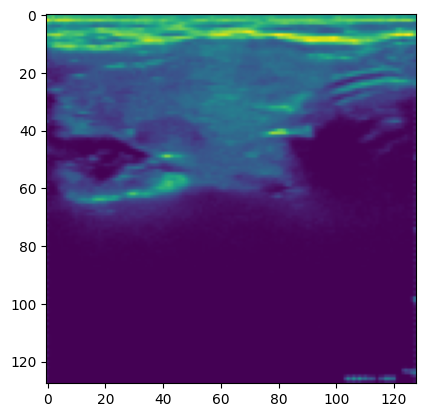

In [27]:
plt.imshow(image[18][0])

In [28]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    
    count = 0
    for image, mask, from_dataset, mask_type, from_inference in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        
        real_ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1) & (from_inference == False)]
        inference_ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1) & (from_inference == True)]
        
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue

        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]

        real_ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1) & (from_inference == False)]
        inference_ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1) & (from_inference == True)]
        
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        # real_ge_nodule_loss = loss_fn(real_ge_nodule_output, real_ge_nodule_mask)
        # inference_ge_nodule_loss = loss_fn(inference_ge_nodule_output, inference_ge_nodule_mask)
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        # nodule_loss = real_ge_nodule_loss * 0.9 + inference_ge_nodule_loss * 0.1
        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio + gland_loss * gland_ratio)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    ge_nodule_IOU = 0
    ge_gland_IOU = 0
    benq_gland_IOU = 0

    ge_nodule_DICE = 0
    ge_gland_DICE = 0
    benq_gland_DICE = 0

    ge_nodule_count = 0
    ge_gland_count = 0
    benq_gland_count = 0
    
    model.eval()
    model.to(device)
    
    for image, mask, from_dataset, mask_type, from_inference in tqdm(dataloader):
        if image == None:
            continue
            
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        if from_dataset[0] == 1 and mask_type[0] == 1:
            loss = loss_fn(ge_nodule_output, ge_nodule_mask)
            IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
            dice_loss = DiceLoss()
            DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)

            ge_nodule_IOU += IOU.item()
            ge_nodule_DICE += DICE.item()
            total_loss += loss.item()
            total_IOU += IOU.item()
            total_DICE += DICE.item()
            ge_nodule_count += 1
        elif from_dataset[0] == 1 and mask_type[0] == 2:
            loss = loss_fn(ge_gland_output, ge_gland_mask)
            IOU = IOU_score(ge_gland_output, ge_gland_mask)
            dice_loss = DiceLoss()
            DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)

            ge_gland_IOU += IOU.item()
            ge_gland_DICE += DICE.item()
            total_loss += loss.item()
            total_IOU += IOU.item()
            total_DICE += DICE.item()
            ge_gland_count += 1
        elif from_dataset[0] == 2 and mask_type[0] == 2:
            loss = loss_fn(benq_gland_output, benq_gland_mask)
            IOU = IOU_score(benq_gland_output, benq_gland_mask)
            dice_loss = DiceLoss()
            DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)
            
            benq_gland_IOU += IOU.item()
            benq_gland_DICE += DICE.item()
            total_loss += loss.item()
            total_IOU += IOU.item()
            total_DICE += DICE.item()
            benq_gland_count += 1
    count = (ge_nodule_count + ge_gland_count + benq_gland_count)
    return total_loss/count , total_IOU/count, total_DICE/count, ge_nodule_IOU/ge_nodule_count, ge_gland_IOU/ge_gland_count, benq_gland_IOU/benq_gland_count, ge_nodule_DICE/ge_nodule_count, ge_gland_DICE/ge_gland_count, benq_gland_DICE/benq_gland_count

    

In [29]:

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3, dropout_rate = 0.0, arch = 68, depth_wise = True, synthesize_adaptive_max_pool = False)


In [30]:

epochs = 300
lr = 0.01
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 1e-4)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [31]:

project = "thyroid_ge_benq_from_scratch"
name = "hybrid_model(68_depth_wise)_ge(nodule_gland_inference)_benq(gland)_from_scratch_v3_1_aug_space(0.9)_weight_decay(1e-4)"
# name = "test"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "augmentation" : "space(0.9)",
        "weight_decay":1e-4
    }
)

In [32]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 300, batch size : 256


In [ ]:
max_IOU = -1
max_nodule_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train, ge_nodule_IOU_train, ge_gland_IOU_train, benq_gland_IOU_train, ge_nodule_DICE_train, ge_gland_DICE_train, benq_gland_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, ge_nodule_IOU_val, ge_gland_IOU_val, benq_gland_IOU_val, ge_nodule_DICE_val, ge_gland_DICE_val, benq_gland_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/from_scratch/ge_benq_inference/{name}/"
        os.makedirs(folder, exist_ok = True)
        torch.save(checkpoint, f"{folder}/best_checkpoint.pth")

    if max_nodule_IOU < ge_nodule_IOU_val:
        max_nodule_IOU = ge_nodule_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/from_scratch/ge_benq_inference/{name}/"
        os.makedirs(folder, exist_ok = True)
        torch.save(checkpoint, f"{folder}/nodule_best_checkpoint.pth")
        
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        "train_ge_nodule_IOU" : ge_nodule_IOU_train,
        "train_ge_nodule_DICE" : ge_nodule_DICE_train,
        "train_ge_gland_IOU" : ge_gland_IOU_train,
        "train_ge_gland_DICE" : ge_gland_DICE_train,
        "train_benq_gland_IOU" : benq_gland_IOU_train,
        "train_benq_gland_DICE" : benq_gland_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        "val_ge_nodule_IOU" : ge_nodule_IOU_val,
        "val_ge_nodule_DICE" : ge_nodule_DICE_val,
        "val_ge_gland_IOU" : ge_gland_IOU_val,
        "val_ge_gland_DICE" : ge_gland_DICE_val,
        "val_benq_gland_IOU" : benq_gland_IOU_val,
        "val_benq_gland_DICE" : benq_gland_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"{folder}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 4/4 [00:12<00:00,  3.07s/it]


train loss : 1.2731604874134064, train IOU : 0.14144130237400532, train DICE : 0.19532624632120132


100%|██████████| 229/229 [00:06<00:00, 36.91it/s]


val loss : 1.2008933370763606, val IOU : 8.885226590677761e-10, val DICE : 0.17667998298250062
epoch : 1


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.962206706404686, train IOU : 0.2614455074071884, train DICE : 0.3469748795032501


100%|██████████| 229/229 [00:05<00:00, 41.54it/s]


val loss : 1.1525296653159942, val IOU : 8.900975439311491e-10, val DICE : 0.18232568827542392
epoch : 2


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


train loss : 0.8253740221261978, train IOU : 0.3892022371292114, train DICE : 0.4395964592695236


100%|██████████| 229/229 [00:05<00:00, 41.62it/s]


val loss : 1.1522985160952868, val IOU : 0.023976051842172334, val DICE : 0.1853892140918308
epoch : 3


100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


train loss : 0.7676196396350861, train IOU : 0.42567282915115356, train DICE : 0.5216101109981537


100%|██████████| 229/229 [00:05<00:00, 41.45it/s]


val loss : 1.1465630874489292, val IOU : 0.15335507157693973, val DICE : 0.20443459141134013
epoch : 4


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.6926259398460388, train IOU : 0.4735008254647255, train DICE : 0.5842436254024506


100%|██████████| 229/229 [00:05<00:00, 41.79it/s]


val loss : 1.1076981611926147, val IOU : 0.230518629804486, val DICE : 0.2483278645409478
epoch : 5


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.6405051052570343, train IOU : 0.5097709000110626, train DICE : 0.624864399433136


100%|██████████| 229/229 [00:05<00:00, 41.17it/s]


val loss : 1.1240485283461483, val IOU : 0.20461286105058177, val DICE : 0.2644916968514221
epoch : 6


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.593778446316719, train IOU : 0.5314502865076065, train DICE : 0.6651442497968674


100%|██████████| 229/229 [00:05<00:00, 41.08it/s]


val loss : 1.1326572937194748, val IOU : 0.21358807826351403, val DICE : 0.27618126134679777
epoch : 7


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.5712104588747025, train IOU : 0.5577698945999146, train DICE : 0.6822959780693054


100%|██████████| 229/229 [00:05<00:00, 41.33it/s]


val loss : 1.1000182970304682, val IOU : 0.2534185857237777, val DICE : 0.3104276545722075
epoch : 8


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.5318796038627625, train IOU : 0.5975340455770493, train DICE : 0.722819447517395


100%|██████████| 229/229 [00:05<00:00, 41.32it/s]


val loss : 1.074011735542856, val IOU : 0.2586441166016889, val DICE : 0.3261034642205094
epoch : 9


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.48756644129753113, train IOU : 0.6184534231821696, train DICE : 0.7374597986539205


100%|██████████| 229/229 [00:05<00:00, 41.12it/s]


val loss : 1.0284171376866524, val IOU : 0.2667211489367615, val DICE : 0.3527803851498498
epoch : 10


100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


train loss : 0.46940360963344574, train IOU : 0.6179978996515274, train DICE : 0.7478321045637131


100%|██████████| 229/229 [00:05<00:00, 41.01it/s]


val loss : 1.0783241141324091, val IOU : 0.2550259295054505, val DICE : 0.3325070904360877
epoch : 11


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.43464455008506775, train IOU : 0.6624322235584259, train DICE : 0.7794720977544785


100%|██████████| 229/229 [00:05<00:00, 41.03it/s]


val loss : 0.9848112104216007, val IOU : 0.30954114134495797, val DICE : 0.40048624560086415
epoch : 12


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.4264924079179764, train IOU : 0.6572264432907104, train DICE : 0.7779904305934906


100%|██████████| 229/229 [00:05<00:00, 40.96it/s]


val loss : 1.0708383547537255, val IOU : 0.27506277878242363, val DICE : 0.33150762861425226
epoch : 13


100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


train loss : 0.40802808105945587, train IOU : 0.6876890361309052, train DICE : 0.8055737465620041


100%|██████████| 229/229 [00:05<00:00, 41.81it/s]


val loss : 0.8486816029657017, val IOU : 0.4080225003776727, val DICE : 0.5170682340559333
epoch : 14


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.3967701345682144, train IOU : 0.6801798790693283, train DICE : 0.8003233224153519


100%|██████████| 229/229 [00:05<00:00, 41.20it/s]


val loss : 1.0222734172235837, val IOU : 0.279016465511327, val DICE : 0.37336315560822536
epoch : 15


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.3679274246096611, train IOU : 0.711509183049202, train DICE : 0.8218839168548584


100%|██████████| 229/229 [00:05<00:00, 41.48it/s]


val loss : 0.8444642123549876, val IOU : 0.41349210882263704, val DICE : 0.5324569184972783
epoch : 16


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.3805513083934784, train IOU : 0.7064842134714127, train DICE : 0.8251967430114746


100%|██████████| 229/229 [00:05<00:00, 40.79it/s]


val loss : 0.9250866261997608, val IOU : 0.37006457138886567, val DICE : 0.46374434955192334
epoch : 17


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.36754024028778076, train IOU : 0.7175469249486923, train DICE : 0.829223096370697


100%|██████████| 229/229 [00:05<00:00, 41.72it/s]


val loss : 0.7567596746364025, val IOU : 0.48244004552823655, val DICE : 0.5891188175389261
epoch : 18


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.3565094272295634, train IOU : 0.7133259375890096, train DICE : 0.8262558778127035


100%|██████████| 229/229 [00:05<00:00, 41.30it/s]


val loss : 0.7727714781508301, val IOU : 0.46997783263290066, val DICE : 0.5844249201543403
epoch : 19


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.35146910697221756, train IOU : 0.7261431813240051, train DICE : 0.8349891901016235


100%|██████████| 229/229 [00:05<00:00, 41.02it/s]


val loss : 0.9218774630565836, val IOU : 0.36941829493371475, val DICE : 0.4608918512710417
epoch : 20


100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


train loss : 0.341281495988369, train IOU : 0.7366327941417694, train DICE : 0.8389991223812103


100%|██████████| 229/229 [00:05<00:00, 41.26it/s]


val loss : 0.7616269818761132, val IOU : 0.4675055812194677, val DICE : 0.572140259574158
epoch : 21


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.3218682110309601, train IOU : 0.7500431388616562, train DICE : 0.8561254888772964


100%|██████████| 229/229 [00:05<00:00, 40.97it/s]


val loss : 0.8840408867055719, val IOU : 0.38956479474495764, val DICE : 0.48011683243693726
epoch : 22


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.3183184713125229, train IOU : 0.7440681457519531, train DICE : 0.8514353036880493


100%|██████████| 229/229 [00:05<00:00, 41.18it/s]


val loss : 0.8953667624731256, val IOU : 0.3774212378022248, val DICE : 0.47834636677395215
epoch : 23


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.3196411728858948, train IOU : 0.7476159930229187, train DICE : 0.8595449477434158


100%|██████████| 229/229 [00:05<00:00, 40.66it/s]


val loss : 0.7717532407153737, val IOU : 0.46785060597838124, val DICE : 0.5658396142299729
epoch : 24


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.30854745705922443, train IOU : 0.7589301864306132, train DICE : 0.8621231913566589


100%|██████████| 229/229 [00:05<00:00, 40.98it/s]


val loss : 0.6799726983664012, val IOU : 0.5336312762892744, val DICE : 0.6420689676747178
epoch : 25


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.2897939831018448, train IOU : 0.7720877677202225, train DICE : 0.8742389231920242


100%|██████████| 229/229 [00:05<00:00, 40.98it/s]


val loss : 0.638870576791691, val IOU : 0.5669622107926238, val DICE : 0.6682346104973494
epoch : 26


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.2989698052406311, train IOU : 0.765557587146759, train DICE : 0.8678274303674698


100%|██████████| 229/229 [00:05<00:00, 41.03it/s]


val loss : 0.6693275874160757, val IOU : 0.5450855961021596, val DICE : 0.6471427368997323
epoch : 27


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.29947490245103836, train IOU : 0.7531503438949585, train DICE : 0.862373560667038


100%|██████████| 229/229 [00:05<00:00, 40.82it/s]


val loss : 0.5938842351538967, val IOU : 0.602367376094564, val DICE : 0.7087919504353495
epoch : 28


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.2901122570037842, train IOU : 0.778201624751091, train DICE : 0.8732490688562393


100%|██████████| 229/229 [00:05<00:00, 40.95it/s]


val loss : 0.6162293962757996, val IOU : 0.5978593670621426, val DICE : 0.7096294297112359
epoch : 29


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.2945748567581177, train IOU : 0.7615547478199005, train DICE : 0.8662779033184052


100%|██████████| 229/229 [00:05<00:00, 40.85it/s]


val loss : 0.5616520590177088, val IOU : 0.6264513161770914, val DICE : 0.7276319596502516
epoch : 30


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.2979114055633545, train IOU : 0.7732259184122086, train DICE : 0.8731071352958679


100%|██████████| 229/229 [00:05<00:00, 40.74it/s]


val loss : 0.5578998431111827, val IOU : 0.6258573138986713, val DICE : 0.7312545758305173
epoch : 31


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


train loss : 0.30544789135456085, train IOU : 0.7686241567134857, train DICE : 0.868772104382515


100%|██████████| 229/229 [00:05<00:00, 40.48it/s]


val loss : 0.598797878194036, val IOU : 0.6148136826660502, val DICE : 0.7174009813202752
epoch : 32


100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


train loss : 0.3125358894467354, train IOU : 0.7567610591650009, train DICE : 0.8593090325593948


100%|██████████| 229/229 [00:05<00:00, 40.96it/s]


val loss : 0.5332984126201181, val IOU : 0.6414558526880295, val DICE : 0.74516077956768
epoch : 33


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.3015221804380417, train IOU : 0.7608944773674011, train DICE : 0.8739833533763885


100%|██████████| 229/229 [00:05<00:00, 40.34it/s]


val loss : 0.49019414163900143, val IOU : 0.6721339143966991, val DICE : 0.7688866332925931
epoch : 34


100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


train loss : 0.2904164269566536, train IOU : 0.7750471532344818, train DICE : 0.86978580057621


100%|██████████| 229/229 [00:05<00:00, 40.48it/s]


val loss : 0.5342090396266995, val IOU : 0.6463627886905453, val DICE : 0.751550122643962
epoch : 35


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.2986167147755623, train IOU : 0.7685766071081161, train DICE : 0.8692261874675751


100%|██████████| 229/229 [00:05<00:00, 40.51it/s]


val loss : 0.5368627393336007, val IOU : 0.6458670732212691, val DICE : 0.7423155548596623
epoch : 36


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


train loss : 0.2718474194407463, train IOU : 0.7833807617425919, train DICE : 0.879892110824585


100%|██████████| 229/229 [00:05<00:00, 40.80it/s]


val loss : 0.5107817057557781, val IOU : 0.666136350700733, val DICE : 0.7633393150989456
epoch : 37


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.26877041906118393, train IOU : 0.7911878675222397, train DICE : 0.883831799030304


100%|██████████| 229/229 [00:05<00:00, 41.01it/s]


val loss : 0.48784919041726327, val IOU : 0.6711622085089466, val DICE : 0.7582594342906066
epoch : 38


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.27370763570070267, train IOU : 0.7910832762718201, train DICE : 0.8880372792482376


100%|██████████| 229/229 [00:05<00:00, 40.49it/s]


val loss : 0.6804377434380127, val IOU : 0.5554847478357268, val DICE : 0.6520925016716274
epoch : 39


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.26696010306477547, train IOU : 0.7885637879371643, train DICE : 0.8879019618034363


100%|██████████| 229/229 [00:05<00:00, 41.18it/s]


val loss : 0.5869770485794905, val IOU : 0.6121338908234936, val DICE : 0.7138686544365354
epoch : 40


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.2795471176505089, train IOU : 0.7889837622642517, train DICE : 0.8821575343608856


100%|██████████| 229/229 [00:05<00:00, 41.09it/s]


val loss : 0.523109514567286, val IOU : 0.655204494623689, val DICE : 0.7543605117484776
epoch : 41


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.2662188336253166, train IOU : 0.788796603679657, train DICE : 0.8853730857372284


100%|██████████| 229/229 [00:05<00:00, 40.85it/s]


val loss : 0.484310120344162, val IOU : 0.6751070643254137, val DICE : 0.7593524031566851
epoch : 42


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.25772541016340256, train IOU : 0.8079325258731842, train DICE : 0.8923109620809555


100%|██████████| 229/229 [00:05<00:00, 40.34it/s]


val loss : 0.5809996843036979, val IOU : 0.608643559130452, val DICE : 0.7091541594327099
epoch : 43


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.26353783160448074, train IOU : 0.7802924364805222, train DICE : 0.8838489055633545


100%|██████████| 229/229 [00:05<00:00, 40.82it/s]


val loss : 0.5846510818134053, val IOU : 0.6130929314056034, val DICE : 0.7149560219711728
epoch : 44


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.26439976692199707, train IOU : 0.8051793873310089, train DICE : 0.889134481549263


100%|██████████| 229/229 [00:05<00:00, 40.54it/s]


val loss : 0.4866180696120166, val IOU : 0.6737091588746608, val DICE : 0.7684122832736584
epoch : 45


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.2652558386325836, train IOU : 0.7835291624069214, train DICE : 0.889577180147171


100%|██████████| 229/229 [00:05<00:00, 40.82it/s]


val loss : 0.5000787323171442, val IOU : 0.6695578681767047, val DICE : 0.7699162541615843
epoch : 46


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.2539566643536091, train IOU : 0.8094438016414642, train DICE : 0.8955784291028976


100%|██████████| 229/229 [00:05<00:00, 40.85it/s]


val loss : 0.48986098106310827, val IOU : 0.6678730976777558, val DICE : 0.7698655522832967
epoch : 47


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.25331513956189156, train IOU : 0.7859878689050674, train DICE : 0.8905771821737289


100%|██████████| 229/229 [00:05<00:00, 40.76it/s]


val loss : 0.5212129921925188, val IOU : 0.6576600241785571, val DICE : 0.7619583976991249
epoch : 48


100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


train loss : 0.2489965409040451, train IOU : 0.8130029737949371, train DICE : 0.898181363940239


100%|██████████| 229/229 [00:05<00:00, 40.77it/s]


val loss : 0.4614344227569874, val IOU : 0.6887584079631004, val DICE : 0.7830987957992939
epoch : 49


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.25604304671287537, train IOU : 0.7886950373649597, train DICE : 0.889947921037674


100%|██████████| 229/229 [00:05<00:00, 40.49it/s]


val loss : 0.45520996230870786, val IOU : 0.7061636971014089, val DICE : 0.7953808978952542
epoch : 50


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


train loss : 0.24213425070047379, train IOU : 0.8112067878246307, train DICE : 0.8945334851741791


100%|██████████| 229/229 [00:05<00:00, 40.44it/s]


val loss : 0.43565940175845164, val IOU : 0.7057048666863317, val DICE : 0.7950930390695129
epoch : 51


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.23970865706602731, train IOU : 0.8163166840871176, train DICE : 0.8998321493466696


100%|██████████| 229/229 [00:05<00:00, 40.63it/s]


val loss : 0.4556655773535521, val IOU : 0.6989554543441129, val DICE : 0.7893095931621513
epoch : 52


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.23552853241562843, train IOU : 0.8137855380773544, train DICE : 0.9041952341794968


100%|██████████| 229/229 [00:05<00:00, 40.94it/s]


val loss : 0.5159891890455978, val IOU : 0.6712025749725542, val DICE : 0.7674513453184956
epoch : 53


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.23904363438487053, train IOU : 0.8059999346733093, train DICE : 0.9024221301078796


100%|██████████| 229/229 [00:05<00:00, 40.83it/s]


val loss : 0.4787161499638148, val IOU : 0.6871654513978207, val DICE : 0.7811396365815942
epoch : 54


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.22941934317350388, train IOU : 0.8117395043373108, train DICE : 0.899067610502243


100%|██████████| 229/229 [00:05<00:00, 41.07it/s]


val loss : 0.5053920132870023, val IOU : 0.67388224536172, val DICE : 0.7760221810653957
epoch : 55


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.22596041858196259, train IOU : 0.8224263787269592, train DICE : 0.9114484637975693


100%|██████████| 229/229 [00:05<00:00, 40.66it/s]


val loss : 0.4558995521881364, val IOU : 0.6912071897683808, val DICE : 0.7896968616981699
epoch : 56


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


train loss : 0.22127969190478325, train IOU : 0.8269555121660233, train DICE : 0.9088219255208969


100%|██████████| 229/229 [00:05<00:00, 41.40it/s]


val loss : 0.4487778174530978, val IOU : 0.6991377938441682, val DICE : 0.7939982877837287
epoch : 57


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.24067163094878197, train IOU : 0.7927946150302887, train DICE : 0.8920231908559799


100%|██████████| 229/229 [00:05<00:00, 40.80it/s]


val loss : 0.5082804171951733, val IOU : 0.6588360057654016, val DICE : 0.7605909127177615
epoch : 58


100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


train loss : 0.24798300489783287, train IOU : 0.8167684078216553, train DICE : 0.8989999443292618


100%|██████████| 229/229 [00:05<00:00, 40.70it/s]


val loss : 0.4792385793695546, val IOU : 0.6830531773227972, val DICE : 0.783503401159036
epoch : 59


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.258047204464674, train IOU : 0.7906491309404373, train DICE : 0.8950315713882446


100%|██████████| 229/229 [00:05<00:00, 40.74it/s]


val loss : 0.52096442565924, val IOU : 0.6810777884944769, val DICE : 0.7833545144760248
epoch : 60


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.2501484453678131, train IOU : 0.807429775595665, train DICE : 0.8953342884778976


100%|██████████| 229/229 [00:05<00:00, 40.57it/s]


val loss : 0.5332378352230246, val IOU : 0.6529345077545626, val DICE : 0.7579181402018575
epoch : 61


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.24563584849238396, train IOU : 0.8041438460350037, train DICE : 0.8948096483945847


100%|██████████| 229/229 [00:05<00:00, 40.64it/s]


val loss : 0.5599607002705035, val IOU : 0.641929849089026, val DICE : 0.7508456267491735
epoch : 62


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.24494054913520813, train IOU : 0.8078481952349345, train DICE : 0.8999840021133423


100%|██████████| 229/229 [00:05<00:00, 41.13it/s]


val loss : 0.49439948703152964, val IOU : 0.6808698304229936, val DICE : 0.7765149389854585
epoch : 63


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.2343272753059864, train IOU : 0.81487175822258, train DICE : 0.9038568735122681


100%|██████████| 229/229 [00:05<00:00, 41.59it/s]


val loss : 0.4756654519399609, val IOU : 0.6867028131817627, val DICE : 0.7905038312228039
epoch : 64


100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


train loss : 0.23934316635131836, train IOU : 0.8293183594942093, train DICE : 0.9037414342164993


100%|██████████| 229/229 [00:05<00:00, 41.25it/s]


val loss : 0.4664518220557107, val IOU : 0.6839463876449386, val DICE : 0.7835554832761938
epoch : 65


100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


train loss : 0.2530157119035721, train IOU : 0.788948193192482, train DICE : 0.8857798725366592


100%|██████████| 229/229 [00:05<00:00, 41.90it/s]


val loss : 0.49367322663616653, val IOU : 0.6820875421206227, val DICE : 0.7807984544773294
epoch : 66


100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


train loss : 0.2576029822230339, train IOU : 0.8043575882911682, train DICE : 0.8944075107574463


100%|██████████| 229/229 [00:05<00:00, 43.46it/s]


val loss : 0.5122800793762159, val IOU : 0.6610785015922426, val DICE : 0.7655273462184752
epoch : 67


100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


train loss : 0.2572280690073967, train IOU : 0.7785029411315918, train DICE : 0.8807793259620667


100%|██████████| 229/229 [00:05<00:00, 43.38it/s]


val loss : 0.5227192933059702, val IOU : 0.6667389536680245, val DICE : 0.7683214403764166
epoch : 68


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.2525004670023918, train IOU : 0.7997822165489197, train DICE : 0.8944731503725052


100%|██████████| 229/229 [00:05<00:00, 40.96it/s]


val loss : 0.5159023615597474, val IOU : 0.6753462163169767, val DICE : 0.7753765574007323
epoch : 69


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.24567348510026932, train IOU : 0.8068753182888031, train DICE : 0.8990155458450317


100%|██████████| 229/229 [00:05<00:00, 41.20it/s]


val loss : 0.4792146531469894, val IOU : 0.6978883332967412, val DICE : 0.7939623612346072
epoch : 70


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.24523410201072693, train IOU : 0.8064234405755997, train DICE : 0.8991124927997589


100%|██████████| 229/229 [00:05<00:00, 41.18it/s]


val loss : 0.41064349610847656, val IOU : 0.723442143579517, val DICE : 0.8077708076347004
epoch : 71


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.24646848812699318, train IOU : 0.8039106726646423, train DICE : 0.8983369022607803


100%|██████████| 229/229 [00:05<00:00, 41.33it/s]


val loss : 0.4209644330119846, val IOU : 0.7177039870195802, val DICE : 0.8030207229383064
epoch : 72


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.22068586945533752, train IOU : 0.8242895305156708, train DICE : 0.9073600769042969


100%|██████████| 229/229 [00:05<00:00, 41.14it/s]


val loss : 0.4561541909069726, val IOU : 0.702296366858663, val DICE : 0.8003375638615001
epoch : 73


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.23245637491345406, train IOU : 0.8239559978246689, train DICE : 0.9047413170337677


100%|██████████| 229/229 [00:05<00:00, 41.43it/s]


val loss : 0.45254840238979366, val IOU : 0.705371752230808, val DICE : 0.8038583397865295
epoch : 74


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


train loss : 0.22791188582777977, train IOU : 0.8142459243535995, train DICE : 0.908963993191719


100%|██████████| 229/229 [00:05<00:00, 41.24it/s]


val loss : 0.4488246872494317, val IOU : 0.7027447923781135, val DICE : 0.7934788468510213
epoch : 75


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.21794672310352325, train IOU : 0.8298286199569702, train DICE : 0.9116719365119934


100%|██████████| 229/229 [00:05<00:00, 41.01it/s]


val loss : 0.41989539198652664, val IOU : 0.7164818403170018, val DICE : 0.8030484932841677
epoch : 76


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.2214283049106598, train IOU : 0.8263473659753799, train DICE : 0.9129200577735901


100%|██████████| 229/229 [00:05<00:00, 41.62it/s]


val loss : 0.4340986027335278, val IOU : 0.7154362434321067, val DICE : 0.8028300091473743
epoch : 77


100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


train loss : 0.2178662046790123, train IOU : 0.8209830820560455, train DICE : 0.9098292589187622


100%|██████████| 229/229 [00:05<00:00, 41.50it/s]


val loss : 0.47890524035601906, val IOU : 0.6876079041214164, val DICE : 0.7837193424653526
epoch : 78


100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


train loss : 0.21562103927135468, train IOU : 0.8291597366333008, train DICE : 0.9106840491294861


100%|██████████| 229/229 [00:05<00:00, 41.67it/s]


val loss : 0.45300932823106493, val IOU : 0.6946938405062356, val DICE : 0.7893002280081162
epoch : 79


100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


train loss : 0.21830622106790543, train IOU : 0.8294946253299713, train DICE : 0.9099416434764862


100%|██████████| 229/229 [00:05<00:00, 41.78it/s]


val loss : 0.4983668423662282, val IOU : 0.6649890768291512, val DICE : 0.7632307145330641
epoch : 80


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.21853408217430115, train IOU : 0.8255926221609116, train DICE : 0.9082268625497818


100%|██████████| 229/229 [00:05<00:00, 41.51it/s]


val loss : 0.4844117745606586, val IOU : 0.6719459877327517, val DICE : 0.7676760575386009
epoch : 81


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.2180073969066143, train IOU : 0.8224513083696365, train DICE : 0.9115783274173737


100%|██████████| 229/229 [00:05<00:00, 41.16it/s]


val loss : 0.5061064905515222, val IOU : 0.6793862314360419, val DICE : 0.7759407623247667
epoch : 82


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


train loss : 0.21807122975587845, train IOU : 0.8262501657009125, train DICE : 0.915059506893158


100%|██████████| 229/229 [00:05<00:00, 41.52it/s]


val loss : 0.5149738555303728, val IOU : 0.6672572219499262, val DICE : 0.7637773312703527
epoch : 83


100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


train loss : 0.2204446643590927, train IOU : 0.8178746998310089, train DICE : 0.9048576653003693


100%|██████████| 229/229 [00:05<00:00, 41.75it/s]


val loss : 0.631295325065201, val IOU : 0.6146141381866871, val DICE : 0.7229737717695911
epoch : 84


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


train loss : 0.23233335092663765, train IOU : 0.8132946342229843, train DICE : 0.9025097787380219


100%|██████████| 229/229 [00:05<00:00, 41.32it/s]


val loss : 0.46598267645546887, val IOU : 0.6954317523880118, val DICE : 0.78847367384217
epoch : 85


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.22501498460769653, train IOU : 0.8287648409605026, train DICE : 0.9072770029306412


100%|██████████| 229/229 [00:05<00:00, 41.03it/s]


val loss : 0.46233331532490374, val IOU : 0.7008880519029407, val DICE : 0.7926697743059409
epoch : 86


100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


train loss : 0.2143357445796331, train IOU : 0.8289177815119425, train DICE : 0.9109853506088257


100%|██████████| 229/229 [00:05<00:00, 41.33it/s]


val loss : 0.4409376532591955, val IOU : 0.7131212316991371, val DICE : 0.8020514376235731
epoch : 87


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.21616145595908165, train IOU : 0.8333104401826859, train DICE : 0.9151335954666138


100%|██████████| 229/229 [00:05<00:00, 41.38it/s]


val loss : 0.4219397094966185, val IOU : 0.7176276596796061, val DICE : 0.8074762610474018
epoch : 88


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.20435400679707527, train IOU : 0.835064098238945, train DICE : 0.9172258079051971


100%|██████████| 229/229 [00:05<00:00, 41.24it/s]


val loss : 0.4116098265530485, val IOU : 0.7263590498594652, val DICE : 0.8118460136230545
epoch : 89


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.20906458795070648, train IOU : 0.8285574615001678, train DICE : 0.9183252602815628


100%|██████████| 229/229 [00:05<00:00, 41.26it/s]


val loss : 0.4307959116619043, val IOU : 0.7139888972793403, val DICE : 0.8004019534347033
epoch : 90


100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


train loss : 0.20600656419992447, train IOU : 0.8364280760288239, train DICE : 0.9175385683774948


100%|██████████| 229/229 [00:05<00:00, 41.61it/s]


val loss : 0.4485246066116925, val IOU : 0.7026064427249655, val DICE : 0.7971485672575055
epoch : 91


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.2329026609659195, train IOU : 0.8097224682569504, train DICE : 0.903955727815628


100%|██████████| 229/229 [00:05<00:00, 42.08it/s]


val loss : 0.4762394203230588, val IOU : 0.6946238146887885, val DICE : 0.791152827366434
epoch : 92


100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


train loss : 0.2308376021683216, train IOU : 0.8187962770462036, train DICE : 0.9097205996513367


100%|██████████| 229/229 [00:05<00:00, 44.55it/s]


val loss : 0.4363806534069355, val IOU : 0.7030961790470162, val DICE : 0.7964778596704657
epoch : 93


100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


train loss : 0.22900128364562988, train IOU : 0.8160531371831894, train DICE : 0.8998601287603378


100%|██████████| 229/229 [00:05<00:00, 44.86it/s]


val loss : 0.49052137204191903, val IOU : 0.6802363105356933, val DICE : 0.7790862303791624
epoch : 94


100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


train loss : 0.21941667795181274, train IOU : 0.8220197558403015, train DICE : 0.9105778485536575


100%|██████████| 229/229 [00:05<00:00, 44.76it/s]


val loss : 0.517971250106289, val IOU : 0.6629438848033173, val DICE : 0.761688002131202
epoch : 95


100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


train loss : 0.218952938914299, train IOU : 0.8318759799003601, train DICE : 0.9136769473552704


100%|██████████| 229/229 [00:05<00:00, 44.66it/s]


val loss : 0.4521934452156226, val IOU : 0.6993457905547262, val DICE : 0.7883457381917973
epoch : 96


100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


train loss : 0.22050116583704948, train IOU : 0.8253790140151978, train DICE : 0.9111368954181671


100%|██████████| 229/229 [00:05<00:00, 44.79it/s]


val loss : 0.4823856326290453, val IOU : 0.6857060197588366, val DICE : 0.7807984833765511
epoch : 97


100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


train loss : 0.21160517260432243, train IOU : 0.8371495455503464, train DICE : 0.9139244109392166


100%|██████████| 229/229 [00:05<00:00, 44.34it/s]


val loss : 0.4544714635445012, val IOU : 0.7024224092116665, val DICE : 0.7974143801915525
epoch : 98


100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


train loss : 0.21540925651788712, train IOU : 0.8165407180786133, train DICE : 0.9054865539073944


100%|██████████| 229/229 [00:05<00:00, 44.76it/s]


val loss : 0.515175846678139, val IOU : 0.6790449002981424, val DICE : 0.7786575149406086
epoch : 99


100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


train loss : 0.20711299777030945, train IOU : 0.8415870368480682, train DICE : 0.9169545918703079


100%|██████████| 229/229 [00:05<00:00, 44.40it/s]


val loss : 0.5056937221400063, val IOU : 0.679890072064668, val DICE : 0.7811078540604524
epoch : 100


100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


train loss : 0.20891137793660164, train IOU : 0.8350637853145599, train DICE : 0.9153528660535812


100%|██████████| 229/229 [00:05<00:00, 44.32it/s]


val loss : 0.4472352003283573, val IOU : 0.7101932706104385, val DICE : 0.802946373067721
epoch : 101


100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


train loss : 0.21253851801156998, train IOU : 0.815372496843338, train DICE : 0.9120775610208511


100%|██████████| 229/229 [00:05<00:00, 44.87it/s]


val loss : 0.43445571756573637, val IOU : 0.7140185851791893, val DICE : 0.8110176704146645
epoch : 102


100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


train loss : 0.19632835313677788, train IOU : 0.8467475175857544, train DICE : 0.9210972040891647


100%|██████████| 229/229 [00:05<00:00, 44.30it/s]


val loss : 0.4148714618023598, val IOU : 0.7282749547651319, val DICE : 0.8214489916960398
epoch : 103


100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


train loss : 0.20460370555520058, train IOU : 0.8296227753162384, train DICE : 0.9145765900611877


100%|██████████| 229/229 [00:05<00:00, 45.01it/s]


val loss : 0.4509274508390162, val IOU : 0.7102961188012903, val DICE : 0.8090591743738964
epoch : 104


100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


train loss : 0.20654850080609322, train IOU : 0.8315658867359161, train DICE : 0.9176391214132309


100%|██████████| 229/229 [00:05<00:00, 44.61it/s]


val loss : 0.47442441825011766, val IOU : 0.6956780659943433, val DICE : 0.7926426069302992
epoch : 105


100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


train loss : 0.20210157334804535, train IOU : 0.8408875018358231, train DICE : 0.9182021915912628


100%|██████████| 229/229 [00:05<00:00, 44.90it/s]


val loss : 0.4199594950886688, val IOU : 0.7217124209485271, val DICE : 0.8130516135933423
epoch : 106


100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


train loss : 0.2064233049750328, train IOU : 0.8331684768199921, train DICE : 0.9193713068962097


100%|██████████| 229/229 [00:05<00:00, 44.17it/s]


val loss : 0.4069747540610607, val IOU : 0.7292124559782972, val DICE : 0.8178554391018068
epoch : 107


100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


train loss : 0.19165685027837753, train IOU : 0.8482824712991714, train DICE : 0.922076866030693


100%|██████████| 229/229 [00:05<00:00, 45.07it/s]


val loss : 0.43827176395088735, val IOU : 0.7167760376238702, val DICE : 0.8087801418521188
epoch : 108


100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


train loss : 0.19275235384702682, train IOU : 0.8536931872367859, train DICE : 0.9249846190214157


100%|██████████| 229/229 [00:05<00:00, 44.77it/s]


val loss : 0.43519936878271775, val IOU : 0.7129662033068667, val DICE : 0.8047736359365059
epoch : 109


100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


train loss : 0.19018007069826126, train IOU : 0.8439952582120895, train DICE : 0.9244100451469421


100%|██████████| 229/229 [00:05<00:00, 44.80it/s]


val loss : 0.45693245481210526, val IOU : 0.7097369669185185, val DICE : 0.8042745752768083
epoch : 110


100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


train loss : 0.1861334852874279, train IOU : 0.857703298330307, train DICE : 0.9310502856969833


100%|██████████| 229/229 [00:05<00:00, 44.75it/s]


val loss : 0.4517380932364801, val IOU : 0.7071787515077483, val DICE : 0.8006772868561022
epoch : 111


100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


train loss : 0.2005612626671791, train IOU : 0.842808410525322, train DICE : 0.9210757166147232


100%|██████████| 229/229 [00:05<00:00, 44.41it/s]


val loss : 0.4402878709287957, val IOU : 0.7107296039516148, val DICE : 0.7994557089275784
epoch : 112


100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


train loss : 0.1969274803996086, train IOU : 0.8384506553411484, train DICE : 0.9195544123649597


100%|██████████| 229/229 [00:05<00:00, 45.25it/s]


val loss : 0.5713037183564721, val IOU : 0.615898490553445, val DICE : 0.7198261871482386
epoch : 113


100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


train loss : 0.20778962969779968, train IOU : 0.8316223174333572, train DICE : 0.9176979511976242


100%|██████████| 229/229 [00:05<00:00, 44.88it/s]


val loss : 0.557500089020139, val IOU : 0.648298136569563, val DICE : 0.7517917418118679
epoch : 114


100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


train loss : 0.19680245965719223, train IOU : 0.8351928293704987, train DICE : 0.9182193279266357


100%|██████████| 229/229 [00:05<00:00, 45.12it/s]


val loss : 0.5404925508932634, val IOU : 0.669435662278344, val DICE : 0.7678521492264487
epoch : 115


100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


train loss : 0.19903817400336266, train IOU : 0.8493359386920929, train DICE : 0.9212112575769424


100%|██████████| 229/229 [00:05<00:00, 44.55it/s]


val loss : 0.4610593878485338, val IOU : 0.6970703310400987, val DICE : 0.7920509880841381
epoch : 116


100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


train loss : 0.19921741634607315, train IOU : 0.8345693945884705, train DICE : 0.9222451895475388


100%|██████████| 229/229 [00:05<00:00, 44.40it/s]


val loss : 0.4758661457459734, val IOU : 0.6948857043371207, val DICE : 0.7908963422582607
epoch : 117


100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


train loss : 0.19751954823732376, train IOU : 0.8457242697477341, train DICE : 0.9210242331027985


100%|██████████| 229/229 [00:05<00:00, 44.84it/s]


val loss : 0.46687234712369513, val IOU : 0.6988172556550809, val DICE : 0.7957567726120804
epoch : 118


100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


train loss : 0.19151980429887772, train IOU : 0.8475744873285294, train DICE : 0.9239191263914108


100%|██████████| 229/229 [00:05<00:00, 44.80it/s]


val loss : 0.44919981845099516, val IOU : 0.7090874191047808, val DICE : 0.8029288321432441
epoch : 119


100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


train loss : 0.20676815882325172, train IOU : 0.8199242204427719, train DICE : 0.917479008436203


100%|██████████| 229/229 [00:05<00:00, 45.34it/s]


val loss : 0.480838227678429, val IOU : 0.6880789413281154, val DICE : 0.7875897035454259
epoch : 120


100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


train loss : 0.2055458426475525, train IOU : 0.8302129656076431, train DICE : 0.9153874814510345


100%|██████████| 229/229 [00:05<00:00, 45.22it/s]


val loss : 0.4239193106615784, val IOU : 0.7175340568176424, val DICE : 0.8116432642093813
epoch : 121


100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


train loss : 0.19494083151221275, train IOU : 0.8441936671733856, train DICE : 0.9200808554887772


100%|██████████| 229/229 [00:05<00:00, 44.44it/s]


val loss : 0.4724009104750373, val IOU : 0.7098318700623378, val DICE : 0.8023099977560718
epoch : 122


100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


train loss : 0.19247427582740784, train IOU : 0.8474091291427612, train DICE : 0.9223570674657822


100%|██████████| 229/229 [00:05<00:00, 44.83it/s]


val loss : 0.44803059195177725, val IOU : 0.7090778252941677, val DICE : 0.7999720898541537
epoch : 123


100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


train loss : 0.19253042340278625, train IOU : 0.8479866832494736, train DICE : 0.9247277230024338


100%|██████████| 229/229 [00:05<00:00, 44.99it/s]


val loss : 0.4489569650454955, val IOU : 0.7078171928736536, val DICE : 0.8010029813857994
epoch : 124


100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


train loss : 0.19437209144234657, train IOU : 0.8440439254045486, train DICE : 0.9231261312961578


100%|██████████| 229/229 [00:05<00:00, 45.06it/s]


val loss : 0.43145828769363537, val IOU : 0.7140005460201074, val DICE : 0.8062733908494314
epoch : 125


100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


train loss : 0.19537001475691795, train IOU : 0.8368037045001984, train DICE : 0.9211058467626572


100%|██████████| 229/229 [00:05<00:00, 44.95it/s]


val loss : 0.44680830512685005, val IOU : 0.7053799320110762, val DICE : 0.8010653016543148
epoch : 126


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.19302384182810783, train IOU : 0.8561503887176514, train DICE : 0.9259828478097916


100%|██████████| 229/229 [00:05<00:00, 41.11it/s]


val loss : 0.4299706422319316, val IOU : 0.7118547886911065, val DICE : 0.8054023553626706
epoch : 127


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.1874363236129284, train IOU : 0.8457375317811966, train DICE : 0.9229055047035217


100%|██████████| 229/229 [00:05<00:00, 41.28it/s]


val loss : 0.45809111111994943, val IOU : 0.7044075692749836, val DICE : 0.7956391157525958
epoch : 128


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.1957588940858841, train IOU : 0.848834291100502, train DICE : 0.926109790802002


100%|██████████| 229/229 [00:05<00:00, 41.72it/s]


val loss : 0.4477741926381684, val IOU : 0.7080121921619984, val DICE : 0.8054976631896664
epoch : 129


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.19999591633677483, train IOU : 0.8325755447149277, train DICE : 0.9192565828561783


100%|██████████| 229/229 [00:05<00:00, 41.44it/s]


val loss : 0.5188324349847707, val IOU : 0.6892019353731714, val DICE : 0.788976517891643
epoch : 130


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.1907856985926628, train IOU : 0.8498967438936234, train DICE : 0.9272860437631607


100%|██████████| 229/229 [00:05<00:00, 41.41it/s]


val loss : 0.4432552692790826, val IOU : 0.7103694507645236, val DICE : 0.8040672435302927
epoch : 131


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.187946654856205, train IOU : 0.8432412892580032, train DICE : 0.9251702129840851


100%|██████████| 229/229 [00:05<00:00, 41.09it/s]


val loss : 0.47884975524261747, val IOU : 0.70326406578388, val DICE : 0.7943152764228859
epoch : 132


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.19939197599887848, train IOU : 0.844345211982727, train DICE : 0.9177931845188141


100%|██████████| 229/229 [00:05<00:00, 41.75it/s]


val loss : 0.4975224992994106, val IOU : 0.6854910268579966, val DICE : 0.7797047122560367
epoch : 133


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.18454208597540855, train IOU : 0.8495544493198395, train DICE : 0.9252149909734726


100%|██████████| 229/229 [00:05<00:00, 41.64it/s]


val loss : 0.49000538780231667, val IOU : 0.6916300884208824, val DICE : 0.7859573445536874
epoch : 134


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.19595815241336823, train IOU : 0.8380170315504074, train DICE : 0.9236288368701935


100%|██████████| 229/229 [00:05<00:00, 41.56it/s]


val loss : 0.4670910636960256, val IOU : 0.7127867022485684, val DICE : 0.8076151946578363
epoch : 135


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.18901995196938515, train IOU : 0.8454633951187134, train DICE : 0.9257224053144455


100%|██████████| 229/229 [00:05<00:00, 41.15it/s]


val loss : 0.46533942233883974, val IOU : 0.7064183972926045, val DICE : 0.8056190862800136
epoch : 136


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.18102166801691055, train IOU : 0.8551480770111084, train DICE : 0.9279701411724091


100%|██████████| 229/229 [00:05<00:00, 41.13it/s]


val loss : 0.4390537780944747, val IOU : 0.7143695361027145, val DICE : 0.8076577987333741
epoch : 137


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.18582560867071152, train IOU : 0.8550925999879837, train DICE : 0.9309938699007034


100%|██████████| 229/229 [00:05<00:00, 41.06it/s]


val loss : 0.4407853895064556, val IOU : 0.7117928949231994, val DICE : 0.8003182164346329
epoch : 138


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.17661074548959732, train IOU : 0.8593755066394806, train DICE : 0.9302287846803665


100%|██████████| 229/229 [00:05<00:00, 41.12it/s]


val loss : 0.44316809451339223, val IOU : 0.7118963551955632, val DICE : 0.8031351725862483
epoch : 139


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.18055544421076775, train IOU : 0.8595704138278961, train DICE : 0.9320206791162491


100%|██████████| 229/229 [00:05<00:00, 40.71it/s]


val loss : 0.4430572423293735, val IOU : 0.7124769449243685, val DICE : 0.8051453205672178
epoch : 140


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.1762610599398613, train IOU : 0.8461064994335175, train DICE : 0.927548810839653


100%|██████████| 229/229 [00:05<00:00, 41.28it/s]


val loss : 0.4462539011781866, val IOU : 0.7204609163585993, val DICE : 0.8049902268732437
epoch : 141


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.17565419897437096, train IOU : 0.8635616153478622, train DICE : 0.9327243864536285


100%|██████████| 229/229 [00:05<00:00, 41.12it/s]


val loss : 0.46509111623721894, val IOU : 0.7092377458582888, val DICE : 0.7977552657777612
epoch : 142


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.18589318916201591, train IOU : 0.8418347537517548, train DICE : 0.9294113367795944


100%|██████████| 229/229 [00:05<00:00, 40.94it/s]


val loss : 0.46914441669077583, val IOU : 0.7034927661324398, val DICE : 0.7966003761147008
epoch : 143


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.18650422617793083, train IOU : 0.8509647101163864, train DICE : 0.9286485612392426


100%|██████████| 229/229 [00:05<00:00, 40.70it/s]


val loss : 0.4516761858731207, val IOU : 0.7154546064001335, val DICE : 0.8044835783616461
epoch : 144


100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


train loss : 0.18084195628762245, train IOU : 0.8608833998441696, train DICE : 0.9304456859827042


100%|██████████| 229/229 [00:05<00:00, 41.00it/s]


val loss : 0.483762271401256, val IOU : 0.706707792264085, val DICE : 0.7998799302361228
epoch : 145


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.17625314742326736, train IOU : 0.8537068963050842, train DICE : 0.9303899705410004


100%|██████████| 229/229 [00:05<00:00, 42.01it/s]


val loss : 0.4655460064308812, val IOU : 0.7060690804440619, val DICE : 0.8010405070251889
epoch : 146


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.18619322031736374, train IOU : 0.8428584635257721, train DICE : 0.9233646094799042


100%|██████████| 229/229 [00:05<00:00, 41.33it/s]


val loss : 0.4564176756850999, val IOU : 0.7216594461657371, val DICE : 0.8133103552490774
epoch : 147


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.19165880978107452, train IOU : 0.851388469338417, train DICE : 0.9285025894641876


100%|██████████| 229/229 [00:05<00:00, 41.80it/s]


val loss : 0.43662837753542744, val IOU : 0.7270829576359252, val DICE : 0.8206971709174339
epoch : 148


100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


train loss : 0.19634609669446945, train IOU : 0.8332067728042603, train DICE : 0.9182710349559784


100%|██████████| 229/229 [00:05<00:00, 41.36it/s]


val loss : 0.4966517308670463, val IOU : 0.697778183642656, val DICE : 0.7911447280585163
epoch : 149


100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


train loss : 0.2013038843870163, train IOU : 0.8393085300922394, train DICE : 0.9247061014175415


100%|██████████| 229/229 [00:05<00:00, 41.56it/s]


val loss : 0.44919601782704843, val IOU : 0.711615024981139, val DICE : 0.8035885471888263
epoch : 150


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.18517551943659782, train IOU : 0.8472001105546951, train DICE : 0.9269895553588867


100%|██████████| 229/229 [00:05<00:00, 41.29it/s]


val loss : 0.44685104304943424, val IOU : 0.7156136513973366, val DICE : 0.8075885727550044
epoch : 151


100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


train loss : 0.1873246543109417, train IOU : 0.8507262617349625, train DICE : 0.9268472343683243


100%|██████████| 229/229 [00:05<00:00, 41.41it/s]


val loss : 0.44923253933137114, val IOU : 0.7123934611788488, val DICE : 0.8037412395380964
epoch : 152


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.18328328803181648, train IOU : 0.846704438328743, train DICE : 0.9276172518730164


100%|██████████| 229/229 [00:05<00:00, 40.99it/s]


val loss : 0.44531198305012, val IOU : 0.7189552494497498, val DICE : 0.8130453490849697
epoch : 153


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.1732495240867138, train IOU : 0.8595222532749176, train DICE : 0.9321533292531967


100%|██████████| 229/229 [00:05<00:00, 40.63it/s]


val loss : 0.4397485703229904, val IOU : 0.7210796072166601, val DICE : 0.813725572643858
epoch : 154


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.17114804312586784, train IOU : 0.8619774729013443, train DICE : 0.9347634166479111


100%|██████████| 229/229 [00:05<00:00, 41.21it/s]


val loss : 0.43807125068975217, val IOU : 0.7238406430049971, val DICE : 0.8169349609601377
epoch : 155


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


train loss : 0.17131619900465012, train IOU : 0.8658050149679184, train DICE : 0.934422954916954


100%|██████████| 229/229 [00:05<00:00, 41.26it/s]


val loss : 0.4500315065561521, val IOU : 0.7152093013188446, val DICE : 0.811552069704942
epoch : 156


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.17244334891438484, train IOU : 0.8596546351909637, train DICE : 0.9312383830547333


100%|██████████| 229/229 [00:05<00:00, 40.41it/s]


val loss : 0.4465626087227855, val IOU : 0.7192562691005829, val DICE : 0.8114153649469819
epoch : 157


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.17906592413783073, train IOU : 0.8570065647363663, train DICE : 0.9301306307315826


100%|██████████| 229/229 [00:05<00:00, 40.23it/s]


val loss : 0.42203935465276843, val IOU : 0.7248804551393689, val DICE : 0.8163316382302178
epoch : 158


100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


train loss : 0.17393940687179565, train IOU : 0.8570512235164642, train DICE : 0.9282394647598267


100%|██████████| 229/229 [00:05<00:00, 40.86it/s]


val loss : 0.43974431773478334, val IOU : 0.7188363570832845, val DICE : 0.8122229329263321
epoch : 159


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.17029793933033943, train IOU : 0.8647376447916031, train DICE : 0.9340510815382004


100%|██████████| 229/229 [00:05<00:00, 39.38it/s]


val loss : 0.4720428321849216, val IOU : 0.7088138222920172, val DICE : 0.805442277530227
epoch : 160


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.16557355597615242, train IOU : 0.8655074238777161, train DICE : 0.9353594928979874


100%|██████████| 229/229 [00:05<00:00, 39.88it/s]


val loss : 0.48642782697623427, val IOU : 0.7106311641859285, val DICE : 0.8068470614727097
epoch : 161


100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


train loss : 0.1718177447716395, train IOU : 0.8619067470232645, train DICE : 0.9356703956921896


100%|██████████| 229/229 [00:05<00:00, 40.19it/s]


val loss : 0.4612434704722178, val IOU : 0.7242896417931618, val DICE : 0.8165077705575963
epoch : 162


100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


train loss : 0.1646730937063694, train IOU : 0.8672822713851929, train DICE : 0.9371796995401382


100%|██████████| 229/229 [00:05<00:00, 39.93it/s]


val loss : 0.4519498104022609, val IOU : 0.7245712110024503, val DICE : 0.8178196865500826
epoch : 163


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.1700643226504326, train IOU : 0.8558655977249146, train DICE : 0.9326384663581848


100%|██████████| 229/229 [00:05<00:00, 40.24it/s]


val loss : 0.4329693613555094, val IOU : 0.7310387495025232, val DICE : 0.8228394024901919
epoch : 164


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


train loss : 0.17877080664038658, train IOU : 0.859734296798706, train DICE : 0.936343640089035


100%|██████████| 229/229 [00:05<00:00, 40.15it/s]


val loss : 0.4112134003127464, val IOU : 0.730363164172329, val DICE : 0.8216884653977673
epoch : 165


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


train loss : 0.17349137738347054, train IOU : 0.8563465029001236, train DICE : 0.9316504895687103


100%|██████████| 229/229 [00:05<00:00, 40.40it/s]


val loss : 0.48090970275377987, val IOU : 0.7065082998438315, val DICE : 0.8028963006506062
epoch : 166


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.16919370368123055, train IOU : 0.871939405798912, train DICE : 0.9388193339109421


100%|██████████| 229/229 [00:05<00:00, 40.43it/s]


val loss : 0.455968167971481, val IOU : 0.7148673647657188, val DICE : 0.810489788199916
epoch : 167


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.17137456312775612, train IOU : 0.8588395118713379, train DICE : 0.9311581999063492


100%|██████████| 229/229 [00:05<00:00, 40.44it/s]


val loss : 0.4547200169828203, val IOU : 0.7149415553044147, val DICE : 0.8055837509608028
epoch : 168


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.16914969310164452, train IOU : 0.8636369854211807, train DICE : 0.9347098618745804


100%|██████████| 229/229 [00:05<00:00, 39.97it/s]


val loss : 0.49161150946159554, val IOU : 0.700103109781871, val DICE : 0.7941663433807065
epoch : 169


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.16718962416052818, train IOU : 0.8702166825532913, train DICE : 0.938264861702919


100%|██████████| 229/229 [00:05<00:00, 40.00it/s]


val loss : 0.4948875021678631, val IOU : 0.6998332555899675, val DICE : 0.7942447183710156
epoch : 170


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.16778859496116638, train IOU : 0.8656041324138641, train DICE : 0.9354947209358215


100%|██████████| 229/229 [00:05<00:00, 39.84it/s]


val loss : 0.47152905726824146, val IOU : 0.7116195245137127, val DICE : 0.8050599176474292
epoch : 171


100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


train loss : 0.16604526713490486, train IOU : 0.8616488426923752, train DICE : 0.9346631914377213


100%|██████████| 229/229 [00:05<00:00, 40.11it/s]


val loss : 0.44894768181021766, val IOU : 0.718459750415083, val DICE : 0.811304767926534
epoch : 172


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


train loss : 0.16546878963708878, train IOU : 0.8606392741203308, train DICE : 0.938166156411171


100%|██████████| 229/229 [00:05<00:00, 39.24it/s]


val loss : 0.4574116511326848, val IOU : 0.7157944077412979, val DICE : 0.8024982918392528
epoch : 173


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


train loss : 0.16085008904337883, train IOU : 0.865770012140274, train DICE : 0.9389909952878952


100%|██████████| 229/229 [00:05<00:00, 40.48it/s]


val loss : 0.44309781002576903, val IOU : 0.7263534400060969, val DICE : 0.8156486373357098
epoch : 174


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.16555635631084442, train IOU : 0.8735437542200089, train DICE : 0.9398843944072723


100%|██████████| 229/229 [00:05<00:00, 40.60it/s]


val loss : 0.45044345856465473, val IOU : 0.7195787919792609, val DICE : 0.8107797647967483
epoch : 175


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.1607247218489647, train IOU : 0.8645994663238525, train DICE : 0.9360178858041763


100%|██████████| 229/229 [00:05<00:00, 41.43it/s]


val loss : 0.4579005239512583, val IOU : 0.7173270844538451, val DICE : 0.8102212274315381
epoch : 176


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.16789276152849197, train IOU : 0.8699061274528503, train DICE : 0.9408998191356659


100%|██████████| 229/229 [00:05<00:00, 41.60it/s]


val loss : 0.44323574461870724, val IOU : 0.7246344102729195, val DICE : 0.8151779701613416
epoch : 177


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.1642789989709854, train IOU : 0.8567366003990173, train DICE : 0.9357709437608719


100%|██████████| 229/229 [00:05<00:00, 40.02it/s]


val loss : 0.4776352789967951, val IOU : 0.707527537792074, val DICE : 0.7995423265177795
epoch : 178


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.1712629236280918, train IOU : 0.856127142906189, train DICE : 0.9372490048408508


100%|██████████| 229/229 [00:05<00:00, 40.55it/s]


val loss : 0.50141821775322, val IOU : 0.6956068280930654, val DICE : 0.7908859611159623
epoch : 179


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.15690239146351814, train IOU : 0.8715984970331192, train DICE : 0.9398287236690521


100%|██████████| 229/229 [00:05<00:00, 43.04it/s]


val loss : 0.5404764928601005, val IOU : 0.6804710148330397, val DICE : 0.7789131830437015
epoch : 180


100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


train loss : 0.16243626549839973, train IOU : 0.8680480420589447, train DICE : 0.9380933195352554


100%|██████████| 229/229 [00:05<00:00, 44.40it/s]


val loss : 0.47347542357565175, val IOU : 0.7119512682559206, val DICE : 0.8065389168984962
epoch : 181


100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


train loss : 0.1541815772652626, train IOU : 0.8721146732568741, train DICE : 0.9393940716981888


100%|██████████| 229/229 [00:05<00:00, 41.81it/s]


val loss : 0.4646731795310372, val IOU : 0.7170105346875455, val DICE : 0.8113337366869955
epoch : 182


100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


train loss : 0.16485168412327766, train IOU : 0.8640302866697311, train DICE : 0.937365934252739


100%|██████████| 229/229 [00:05<00:00, 41.67it/s]


val loss : 0.4398272963936883, val IOU : 0.7268926789391789, val DICE : 0.8183419665302893
epoch : 183


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.15148484334349632, train IOU : 0.8779491931200027, train DICE : 0.9406121522188187


100%|██████████| 229/229 [00:05<00:00, 41.89it/s]


val loss : 0.43595609896712834, val IOU : 0.7257957863762523, val DICE : 0.8185834327731469
epoch : 184


100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


train loss : 0.15960479155182838, train IOU : 0.8698785603046417, train DICE : 0.9422234743833542


100%|██████████| 229/229 [00:05<00:00, 41.92it/s]


val loss : 0.4368034492463175, val IOU : 0.723671259461971, val DICE : 0.817475577496519
epoch : 185


100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


train loss : 0.1553567498922348, train IOU : 0.8714159280061722, train DICE : 0.9407317787408829


100%|██████████| 229/229 [00:05<00:00, 41.95it/s]


val loss : 0.4440190194532125, val IOU : 0.7217977577063128, val DICE : 0.8152361153954207
epoch : 186


100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


train loss : 0.1554592214524746, train IOU : 0.8713016360998154, train DICE : 0.9422454684972763


100%|██████████| 229/229 [00:05<00:00, 41.69it/s]


val loss : 0.4579418023126294, val IOU : 0.712998931516688, val DICE : 0.8055514843776973
epoch : 187


100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


train loss : 0.1561519131064415, train IOU : 0.8690050691366196, train DICE : 0.9420501291751862


100%|██████████| 229/229 [00:05<00:00, 42.00it/s]


val loss : 0.4594879916897326, val IOU : 0.713357628296043, val DICE : 0.8041250543160872
epoch : 188


100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


train loss : 0.16297006607055664, train IOU : 0.8668474704027176, train DICE : 0.9403260350227356


100%|██████████| 229/229 [00:05<00:00, 41.12it/s]


val loss : 0.49796660609468063, val IOU : 0.6931681393976964, val DICE : 0.7906737116852192
epoch : 189


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.16085010394454002, train IOU : 0.8718425631523132, train DICE : 0.9406095445156097


100%|██████████| 229/229 [00:05<00:00, 40.55it/s]


val loss : 0.4471232787226186, val IOU : 0.7192559691968585, val DICE : 0.8153400830548219
epoch : 190


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.15620171278715134, train IOU : 0.8711290508508682, train DICE : 0.9408365935087204


100%|██████████| 229/229 [00:05<00:00, 40.10it/s]


val loss : 0.44415557166241637, val IOU : 0.72645156514464, val DICE : 0.8212945145187955
epoch : 191


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.16360527649521828, train IOU : 0.8703711181879044, train DICE : 0.9387753754854202


100%|██████████| 229/229 [00:05<00:00, 40.96it/s]


val loss : 0.4296167259189216, val IOU : 0.7256610583175312, val DICE : 0.8212629451294138
epoch : 192


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.1620195396244526, train IOU : 0.8657326400279999, train DICE : 0.9396840929985046


100%|██████████| 229/229 [00:05<00:00, 40.45it/s]


val loss : 0.4414467848461084, val IOU : 0.7187166228476498, val DICE : 0.8143733065537732
epoch : 193


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


train loss : 0.14774079248309135, train IOU : 0.8819780796766281, train DICE : 0.9439669698476791


100%|██████████| 229/229 [00:05<00:00, 40.44it/s]


val loss : 0.45497313958376345, val IOU : 0.7169606360657835, val DICE : 0.8105945499858471
epoch : 194


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


train loss : 0.1516289822757244, train IOU : 0.8764510601758957, train DICE : 0.9402128756046295


100%|██████████| 229/229 [00:05<00:00, 39.64it/s]


val loss : 0.49607135569958977, val IOU : 0.7042798312892595, val DICE : 0.8017443111448577
epoch : 195


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.15728378295898438, train IOU : 0.8702718615531921, train DICE : 0.9412130316098531


100%|██████████| 229/229 [00:05<00:00, 39.87it/s]


val loss : 0.4535021837236303, val IOU : 0.7216770681076766, val DICE : 0.8158117710339903
epoch : 202


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.15414725989103317, train IOU : 0.8767513781785965, train DICE : 0.9434192478656769


100%|██████████| 229/229 [00:05<00:00, 40.48it/s]


val loss : 0.44382248995731577, val IOU : 0.7235602145869096, val DICE : 0.8180138586145459
epoch : 203


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.15522225573658943, train IOU : 0.8659039884805679, train DICE : 0.9401892125606537


100%|██████████| 229/229 [00:05<00:00, 40.11it/s]


val loss : 0.4521831636778032, val IOU : 0.7220181160328516, val DICE : 0.8151774876045458
epoch : 204


100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


train loss : 0.15193993225693703, train IOU : 0.8723530620336533, train DICE : 0.9410218447446823


100%|██████████| 229/229 [00:05<00:00, 40.76it/s]


val loss : 0.495913532346186, val IOU : 0.7038282314707374, val DICE : 0.8009757333331637
epoch : 205


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.1470615230500698, train IOU : 0.879385456442833, train DICE : 0.9432298392057419


100%|██████████| 229/229 [00:05<00:00, 40.91it/s]


val loss : 0.49802425943992357, val IOU : 0.6975913340808466, val DICE : 0.7950796328409754
epoch : 206


100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


train loss : 0.14843707904219627, train IOU : 0.8773818761110306, train DICE : 0.9428984075784683


100%|██████████| 229/229 [00:05<00:00, 40.66it/s]


val loss : 0.4719535585756254, val IOU : 0.7148535161193509, val DICE : 0.8084300283831779
epoch : 207


100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


train loss : 0.14707097907861075, train IOU : 0.8793024023373922, train DICE : 0.9443519711494446


100%|██████████| 229/229 [00:05<00:00, 39.63it/s]


val loss : 0.48181872803604964, val IOU : 0.7133453219460341, val DICE : 0.8083659169649837
epoch : 208


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.14126910269260406, train IOU : 0.8831436336040497, train DICE : 0.9457993656396866


100%|██████████| 229/229 [00:05<00:00, 41.94it/s]


val loss : 0.5018046683434284, val IOU : 0.7024657621879007, val DICE : 0.7997274311503979
epoch : 209


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.15653348714113235, train IOU : 0.8747807145118713, train DICE : 0.943159818649292


100%|██████████| 229/229 [00:05<00:00, 42.03it/s]


val loss : 0.4791877744625313, val IOU : 0.7114634754171774, val DICE : 0.8070975650440563
epoch : 210


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.14908001199364662, train IOU : 0.879602387547493, train DICE : 0.9441935420036316


100%|██████████| 229/229 [00:05<00:00, 42.33it/s]


val loss : 0.5074789514671071, val IOU : 0.6951862129663845, val DICE : 0.7907129225104746
epoch : 211


100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


train loss : 0.1431809514760971, train IOU : 0.8836350589990616, train DICE : 0.9447190463542938


100%|██████████| 229/229 [00:05<00:00, 41.62it/s]


val loss : 0.49994779178741, val IOU : 0.70245410766109, val DICE : 0.7966501800098804
epoch : 212


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.14925217255949974, train IOU : 0.8823231905698776, train DICE : 0.9468259215354919


100%|██████████| 229/229 [00:05<00:00, 40.63it/s]


val loss : 0.48331056411067647, val IOU : 0.7110145107880366, val DICE : 0.8053120892457287
epoch : 213


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.14694348350167274, train IOU : 0.877788245677948, train DICE : 0.944749116897583


100%|██████████| 229/229 [00:05<00:00, 40.79it/s]


val loss : 0.5063027671039707, val IOU : 0.7012915015845815, val DICE : 0.7977521783775754
epoch : 214


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.14428942650556564, train IOU : 0.8811137527227402, train DICE : 0.9448105543851852


100%|██████████| 229/229 [00:05<00:00, 43.52it/s]


val loss : 0.5274012490279145, val IOU : 0.6951840804458008, val DICE : 0.7938530574543308
epoch : 215


100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


train loss : 0.14094172418117523, train IOU : 0.878966897726059, train DICE : 0.9467285722494125


100%|██████████| 229/229 [00:05<00:00, 44.31it/s]


val loss : 0.5299054462500293, val IOU : 0.6921463472037024, val DICE : 0.7913173647842022
epoch : 216


100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


train loss : 0.14363209158182144, train IOU : 0.8861695975065231, train DICE : 0.9467036873102188


100%|██████████| 229/229 [00:05<00:00, 44.88it/s]


val loss : 0.513997059503589, val IOU : 0.6961226462918746, val DICE : 0.7933583434181984
epoch : 217


100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


train loss : 0.14300085231661797, train IOU : 0.8788228929042816, train DICE : 0.9474577158689499


100%|██████████| 229/229 [00:05<00:00, 44.08it/s]


val loss : 0.4997564512446071, val IOU : 0.7011461611627445, val DICE : 0.7971721405934806
epoch : 218


100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


train loss : 0.14501883834600449, train IOU : 0.8820182681083679, train DICE : 0.9453883171081543


100%|██████████| 229/229 [00:05<00:00, 44.24it/s]


val loss : 0.5000472728426408, val IOU : 0.7051601458999215, val DICE : 0.8011135871362205
epoch : 219


100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


train loss : 0.1443449892103672, train IOU : 0.8823790848255157, train DICE : 0.9482698440551758


100%|██████████| 229/229 [00:05<00:00, 44.20it/s]


val loss : 0.5017627551775388, val IOU : 0.7063619216990632, val DICE : 0.8039458330833551
epoch : 220


100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


train loss : 0.13991359621286392, train IOU : 0.8819855153560638, train DICE : 0.9464164525270462


100%|██████████| 229/229 [00:05<00:00, 44.18it/s]


val loss : 0.5011616354864655, val IOU : 0.7062129614730902, val DICE : 0.8049298880076168
epoch : 221


100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


train loss : 0.14697440713644028, train IOU : 0.8657514005899429, train DICE : 0.943556159734726


100%|██████████| 229/229 [00:05<00:00, 44.06it/s]


val loss : 0.4899777149160703, val IOU : 0.7118142650801208, val DICE : 0.8078224845606872
epoch : 222


100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


train loss : 0.14831563457846642, train IOU : 0.8826020061969757, train DICE : 0.9483336955308914


100%|██████████| 229/229 [00:05<00:00, 44.51it/s]


val loss : 0.5016935008267561, val IOU : 0.7081820196856332, val DICE : 0.8023819125661946
epoch : 223


100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


train loss : 0.14819827303290367, train IOU : 0.8731452524662018, train DICE : 0.9433998614549637


100%|██████████| 229/229 [00:05<00:00, 44.19it/s]


val loss : 0.5163319475873552, val IOU : 0.6967108723168252, val DICE : 0.7931612176124496
epoch : 224


100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


train loss : 0.13902965560555458, train IOU : 0.8884650468826294, train DICE : 0.9467932879924774


100%|██████████| 229/229 [00:05<00:00, 44.70it/s]


val loss : 0.5436915026770698, val IOU : 0.6903495402532998, val DICE : 0.7874995855369953
epoch : 225


100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


train loss : 0.14202927549680075, train IOU : 0.8878994981447855, train DICE : 0.9473135272661845


100%|██████████| 229/229 [00:05<00:00, 44.42it/s]


val loss : 0.49893094934146814, val IOU : 0.7086741181609691, val DICE : 0.8063939848933557
epoch : 226


100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


train loss : 0.15249677374958992, train IOU : 0.8718335628509521, train DICE : 0.9392917603254318


100%|██████████| 229/229 [00:05<00:00, 44.30it/s]


val loss : 0.48969822393899615, val IOU : 0.7156211758026915, val DICE : 0.8110270452017736
epoch : 227


100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


train loss : 0.14054234698414803, train IOU : 0.8889992535114288, train DICE : 0.9487867206335068


100%|██████████| 229/229 [00:05<00:00, 44.40it/s]


val loss : 0.47399494830857625, val IOU : 0.7187708486578246, val DICE : 0.8143568586821508
epoch : 228


100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


train loss : 0.14223383367061615, train IOU : 0.8803642839193344, train DICE : 0.9473291486501694


100%|██████████| 229/229 [00:05<00:00, 43.91it/s]


val loss : 0.47553211510783494, val IOU : 0.7152323489116049, val DICE : 0.8127190624222611
epoch : 229


100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


train loss : 0.13847874850034714, train IOU : 0.8853492438793182, train DICE : 0.9470186531543732


100%|██████████| 229/229 [00:05<00:00, 44.90it/s]


val loss : 0.4923803647886021, val IOU : 0.7113930449931591, val DICE : 0.809295963157307
epoch : 230


100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


train loss : 0.1373143494129181, train IOU : 0.8892408907413483, train DICE : 0.9492462873458862


100%|██████████| 229/229 [00:05<00:00, 44.44it/s]


val loss : 0.49548774190021283, val IOU : 0.7127880887687982, val DICE : 0.8107825358106633
epoch : 231


100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


train loss : 0.13866242269674936, train IOU : 0.887840986251831, train DICE : 0.9482142329216003


100%|██████████| 229/229 [00:05<00:00, 43.48it/s]


val loss : 0.500616339910211, val IOU : 0.7131262026633896, val DICE : 0.8102012234504776
epoch : 232


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.14298297837376595, train IOU : 0.8866884857416153, train DICE : 0.9489281326532364


100%|██████████| 229/229 [00:05<00:00, 42.05it/s]


val loss : 0.4843863533301787, val IOU : 0.7186942277885895, val DICE : 0.814514929598028
epoch : 233


100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


train loss : 0.13603024184703827, train IOU : 0.885688379406929, train DICE : 0.9481623619794846


100%|██████████| 229/229 [00:05<00:00, 41.52it/s]


val loss : 0.49562220079730257, val IOU : 0.7121551684769399, val DICE : 0.807889522326113
epoch : 234


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


train loss : 0.13765311613678932, train IOU : 0.8835159540176392, train DICE : 0.9485407769680023


100%|██████████| 229/229 [00:05<00:00, 42.87it/s]


val loss : 0.5004722230286911, val IOU : 0.7124441074211127, val DICE : 0.8068747568612147
epoch : 235


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.1390838734805584, train IOU : 0.8910496234893799, train DICE : 0.9470954388380051


100%|██████████| 229/229 [00:05<00:00, 40.05it/s]


val loss : 0.4833670941868214, val IOU : 0.7188593249392082, val DICE : 0.8147229037501595
epoch : 241


100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


train loss : 0.13546060770750046, train IOU : 0.8889850825071335, train DICE : 0.9492979943752289


100%|██████████| 229/229 [00:05<00:00, 40.05it/s]


val loss : 0.49648183937927687, val IOU : 0.7137481135365215, val DICE : 0.8096284249214211
epoch : 242


100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


train loss : 0.13618474453687668, train IOU : 0.8841892778873444, train DICE : 0.94390968978405


100%|██████████| 229/229 [00:05<00:00, 40.20it/s]


val loss : 0.5042551678012718, val IOU : 0.7104019091131502, val DICE : 0.8059279000518298
epoch : 243


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


train loss : 0.132733803242445, train IOU : 0.8971924483776093, train DICE : 0.9517515301704407


100%|██████████| 229/229 [00:05<00:00, 39.28it/s]


val loss : 0.4990793850385781, val IOU : 0.7121724262788114, val DICE : 0.8085165047886396
epoch : 244


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.13623958453536034, train IOU : 0.8904979079961777, train DICE : 0.9493768364191055


100%|██████████| 229/229 [00:05<00:00, 40.75it/s]


val loss : 0.512021765526798, val IOU : 0.7055761228272339, val DICE : 0.8029552662011349
epoch : 245


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


train loss : 0.13599448278546333, train IOU : 0.887384682893753, train DICE : 0.9486861377954483


100%|██████████| 229/229 [00:05<00:00, 40.04it/s]


val loss : 0.5014712136201184, val IOU : 0.7101213592197068, val DICE : 0.8069289308605772
epoch : 246


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.13760509714484215, train IOU : 0.8860911428928375, train DICE : 0.9494132846593857


100%|██████████| 229/229 [00:05<00:00, 40.06it/s]


val loss : 0.5155420021878349, val IOU : 0.7061233015349855, val DICE : 0.8027225356511395
epoch : 247


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.1277858316898346, train IOU : 0.8922589421272278, train DICE : 0.9510280787944794


100%|██████████| 229/229 [00:05<00:00, 40.10it/s]


val loss : 0.5017056243136676, val IOU : 0.7104125586565052, val DICE : 0.8061877678741108
epoch : 248


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


train loss : 0.1351296380162239, train IOU : 0.8841716796159744, train DICE : 0.9484343826770782


100%|██████████| 229/229 [00:05<00:00, 39.55it/s]


val loss : 0.48924948779320476, val IOU : 0.7135320892458549, val DICE : 0.8100067930992203
epoch : 249


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train loss : 0.13577958568930626, train IOU : 0.8868655413389206, train DICE : 0.9492738246917725


100%|██████████| 229/229 [00:05<00:00, 39.79it/s]


val loss : 0.4809939327715623, val IOU : 0.7162278632186537, val DICE : 0.8125822390570785
epoch : 250


100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


train loss : 0.13241226226091385, train IOU : 0.8938927352428436, train DICE : 0.9517176002264023


100%|██████████| 229/229 [00:05<00:00, 39.52it/s]


val loss : 0.4977949165710897, val IOU : 0.7097039848956453, val DICE : 0.8067656294866041
epoch : 251


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


train loss : 0.13331850245594978, train IOU : 0.8845670372247696, train DICE : 0.9491805136203766


100%|██████████| 229/229 [00:05<00:00, 40.16it/s]


val loss : 0.4839129870512871, val IOU : 0.7141695885509812, val DICE : 0.8094921906789144
epoch : 252


100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


train loss : 0.1368882842361927, train IOU : 0.8927776217460632, train DICE : 0.9488386362791061


100%|██████████| 229/229 [00:05<00:00, 40.46it/s]


val loss : 0.4791276457935873, val IOU : 0.71834152123157, val DICE : 0.8122720083202979
epoch : 253


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


train loss : 0.13329141959547997, train IOU : 0.8862756341695786, train DICE : 0.9499563425779343


100%|██████████| 229/229 [00:05<00:00, 40.79it/s]


val loss : 0.49832275904940837, val IOU : 0.7117142801314136, val DICE : 0.8080205128650473
epoch : 254


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


train loss : 0.13128936290740967, train IOU : 0.8901956379413605, train DICE : 0.9517213255167007


100%|██████████| 229/229 [00:05<00:00, 40.42it/s]


val loss : 0.5124713022901555, val IOU : 0.7072366618386682, val DICE : 0.8047886873134459
epoch : 255


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.12952709570527077, train IOU : 0.8937244117259979, train DICE : 0.9522790014743805


100%|██████████| 229/229 [00:05<00:00, 39.90it/s]


val loss : 0.5075509683276066, val IOU : 0.7090476396973381, val DICE : 0.8065641492304175
epoch : 256


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


train loss : 0.12951772287487984, train IOU : 0.8925703465938568, train DICE : 0.9519528299570084


100%|██████████| 229/229 [00:05<00:00, 39.67it/s]


val loss : 0.49869045340503104, val IOU : 0.7113812206043697, val DICE : 0.8081514206197526
epoch : 257


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.12913182377815247, train IOU : 0.8917184770107269, train DICE : 0.9499489665031433


100%|██████████| 229/229 [00:05<00:00, 40.63it/s]


val loss : 0.5036807556194488, val IOU : 0.7090642124044465, val DICE : 0.8059593008624183
epoch : 258


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.1317773573100567, train IOU : 0.898288682103157, train DICE : 0.9529697299003601


100%|██████████| 229/229 [00:05<00:00, 40.83it/s]


val loss : 0.523608544784965, val IOU : 0.7010535895049015, val DICE : 0.7983032982758801
epoch : 259


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.1309531405568123, train IOU : 0.8931231200695038, train DICE : 0.9521415829658508


100%|██████████| 229/229 [00:05<00:00, 40.98it/s]


val loss : 0.502058727836067, val IOU : 0.7079191294973928, val DICE : 0.8038187526693248
epoch : 260


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.13180308789014816, train IOU : 0.8887783885002136, train DICE : 0.948887899518013


100%|██████████| 229/229 [00:05<00:00, 41.43it/s]


val loss : 0.5017128284606669, val IOU : 0.707235913232044, val DICE : 0.8034468100528525
epoch : 261


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.13043425604701042, train IOU : 0.8871098011732101, train DICE : 0.9518523514270782


100%|██████████| 229/229 [00:05<00:00, 41.04it/s]


val loss : 0.5229402766610035, val IOU : 0.7011958266196294, val DICE : 0.7986604342556963
epoch : 262


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.13117965310811996, train IOU : 0.8930470049381256, train DICE : 0.9519743472337723


100%|██████████| 229/229 [00:05<00:00, 40.94it/s]


val loss : 0.510079957996354, val IOU : 0.7075555008813258, val DICE : 0.8047833334315907
epoch : 263


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.12873803079128265, train IOU : 0.8933917731046677, train DICE : 0.9525610953569412


100%|██████████| 229/229 [00:05<00:00, 41.06it/s]


val loss : 0.49060816028051907, val IOU : 0.715099438570073, val DICE : 0.811544719669554
epoch : 264


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.12729525938630104, train IOU : 0.8966983556747437, train DICE : 0.9524935185909271


100%|██████████| 229/229 [00:05<00:00, 40.87it/s]


val loss : 0.49373676029570174, val IOU : 0.7135091140606556, val DICE : 0.8100122818441102
epoch : 265


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.12868086621165276, train IOU : 0.8973144441843033, train DICE : 0.9521481543779373


100%|██████████| 229/229 [00:05<00:00, 41.01it/s]


val loss : 0.5120981775525243, val IOU : 0.7059917450296203, val DICE : 0.8035654675478887
epoch : 266


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.12675415351986885, train IOU : 0.8901894837617874, train DICE : 0.9497075378894806


100%|██████████| 229/229 [00:05<00:00, 41.66it/s]


val loss : 0.5080660655718259, val IOU : 0.7081125345085274, val DICE : 0.8054076752277336
epoch : 267


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.12977220863103867, train IOU : 0.8926124721765518, train DICE : 0.95114965736866


100%|██████████| 229/229 [00:05<00:00, 41.69it/s]


val loss : 0.5051469839356765, val IOU : 0.7089721338809837, val DICE : 0.8064371519016497
epoch : 268


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.1294330582022667, train IOU : 0.890247642993927, train DICE : 0.950658917427063


100%|██████████| 229/229 [00:05<00:00, 41.49it/s]


val loss : 0.4912997684018178, val IOU : 0.7150460347274862, val DICE : 0.8113768401772085
epoch : 269


100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


train loss : 0.1281036635239919, train IOU : 0.8953707416852316, train DICE : 0.9518671830495199


100%|██████████| 229/229 [00:05<00:00, 41.58it/s]


val loss : 0.5029714870633502, val IOU : 0.7107096507436031, val DICE : 0.8077041271961096
epoch : 270


100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


train loss : 0.1286955587565899, train IOU : 0.8923918008804321, train DICE : 0.9521320909261703


100%|██████████| 229/229 [00:05<00:00, 41.51it/s]


val loss : 0.5111237629646003, val IOU : 0.7074092652503299, val DICE : 0.8046807761144157
epoch : 271


100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


train loss : 0.12521006911993027, train IOU : 0.8938271999359131, train DICE : 0.9522260874509811


100%|██████████| 229/229 [00:05<00:00, 41.16it/s]


val loss : 0.5119103759978757, val IOU : 0.7064705363845352, val DICE : 0.8038563165399764
epoch : 272


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.12675867974758148, train IOU : 0.8980809897184372, train DICE : 0.9536450356245041


100%|██████████| 229/229 [00:05<00:00, 41.19it/s]


val loss : 0.5092544592916965, val IOU : 0.7080709655743725, val DICE : 0.8049082181068382
epoch : 273


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.1263730823993683, train IOU : 0.8980445861816406, train DICE : 0.9526408761739731


100%|██████████| 229/229 [00:05<00:00, 41.59it/s]


val loss : 0.5015603794217712, val IOU : 0.7117881486251894, val DICE : 0.8079181202132293
epoch : 274


100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


train loss : 0.12662256881594658, train IOU : 0.8970094621181488, train DICE : 0.9536467790603638


100%|██████████| 229/229 [00:05<00:00, 41.34it/s]


val loss : 0.49941271216128813, val IOU : 0.7127774288145977, val DICE : 0.8092754751142829
epoch : 275


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.12803201749920845, train IOU : 0.897656187415123, train DICE : 0.9529717415571213


100%|██████████| 229/229 [00:05<00:00, 41.05it/s]


val loss : 0.5009743932145413, val IOU : 0.7134530350079028, val DICE : 0.8096492118907698
epoch : 276


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.12513262778520584, train IOU : 0.8948477208614349, train DICE : 0.9519558399915695


100%|██████████| 229/229 [00:05<00:00, 41.13it/s]


val loss : 0.5090587770171238, val IOU : 0.7100038611191118, val DICE : 0.8070092800289693
epoch : 277


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


train loss : 0.1302083022892475, train IOU : 0.8977616429328918, train DICE : 0.9530889838933945


100%|██████████| 229/229 [00:05<00:00, 41.44it/s]


val loss : 0.5138119003462671, val IOU : 0.7081540920784334, val DICE : 0.8053468923376064
epoch : 278


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.12739423103630543, train IOU : 0.8958410173654556, train DICE : 0.9537616521120071


100%|██████████| 229/229 [00:05<00:00, 41.60it/s]


val loss : 0.5097952730803177, val IOU : 0.709075966601832, val DICE : 0.8062678482195343
epoch : 279


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


train loss : 0.1300978697836399, train IOU : 0.8897370994091034, train DICE : 0.9507041126489639


100%|██████████| 229/229 [00:05<00:00, 41.43it/s]


val loss : 0.509969275632892, val IOU : 0.7084433322718396, val DICE : 0.8054830272390385
epoch : 280


100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


train loss : 0.1232256069779396, train IOU : 0.8928829282522202, train DICE : 0.9517984837293625


100%|██████████| 229/229 [00:05<00:00, 41.40it/s]


val loss : 0.507311894962884, val IOU : 0.7094993639813827, val DICE : 0.80630137071465
epoch : 281


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


train loss : 0.1236175112426281, train IOU : 0.8978842794895172, train DICE : 0.9516966938972473


100%|██████████| 229/229 [00:05<00:00, 41.24it/s]


val loss : 0.5080371371122322, val IOU : 0.7092439514932243, val DICE : 0.8062472210990058
epoch : 282


100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


train loss : 0.12906108424067497, train IOU : 0.8865919709205627, train DICE : 0.9520956426858902


100%|██████████| 229/229 [00:05<00:00, 41.87it/s]


val loss : 0.5089061354672668, val IOU : 0.7097241027299793, val DICE : 0.8067229567754148
epoch : 283


100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


train loss : 0.1272634044289589, train IOU : 0.8936447650194168, train DICE : 0.9522056728601456


100%|██████████| 229/229 [00:05<00:00, 41.49it/s]


val loss : 0.5121736965621962, val IOU : 0.7087842496169942, val DICE : 0.8058343255760694
epoch : 284


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train loss : 0.1272384189069271, train IOU : 0.8990901112556458, train DICE : 0.9549584835767746


100%|██████████| 229/229 [00:05<00:00, 41.38it/s]


val loss : 0.5131207453181045, val IOU : 0.7085196160571671, val DICE : 0.80567636273124
epoch : 285


100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


train loss : 0.12381863035261631, train IOU : 0.8992322981357574, train DICE : 0.954211562871933


100%|██████████| 229/229 [00:05<00:00, 41.30it/s]


val loss : 0.5094088970335445, val IOU : 0.7096692937380202, val DICE : 0.8067225127509146
epoch : 286


100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


train loss : 0.12915128841996193, train IOU : 0.8948495984077454, train DICE : 0.9531471580266953


100%|██████████| 229/229 [00:05<00:00, 41.23it/s]


val loss : 0.5071008085752978, val IOU : 0.7104571389392382, val DICE : 0.8071825757171168
epoch : 287


100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


train loss : 0.12689388915896416, train IOU : 0.89299076795578, train DICE : 0.9521397352218628


100%|██████████| 229/229 [00:05<00:00, 42.04it/s]


val loss : 0.5022868196470569, val IOU : 0.7121452277471092, val DICE : 0.8088026754181794
epoch : 288


100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


train loss : 0.1284914556890726, train IOU : 0.8904923647642136, train DICE : 0.9509443193674088


100%|██████████| 229/229 [00:05<00:00, 41.59it/s]


val loss : 0.5037553691578032, val IOU : 0.7112979015127813, val DICE : 0.8080382642119822
epoch : 289


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


train loss : 0.12559440918266773, train IOU : 0.8956812471151352, train DICE : 0.9522150903940201


100%|██████████| 229/229 [00:05<00:00, 42.17it/s]


val loss : 0.5019882725871573, val IOU : 0.7119820938603958, val DICE : 0.8087846922754037
epoch : 290


100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


train loss : 0.12970386818051338, train IOU : 0.8938191533088684, train DICE : 0.9516159147024155


100%|██████████| 229/229 [00:05<00:00, 44.00it/s]


val loss : 0.5058977538437555, val IOU : 0.7103547652899042, val DICE : 0.8071370883421465
epoch : 291


100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


train loss : 0.12555791437625885, train IOU : 0.8934426506360372, train DICE : 0.9531457821528116


100%|██████████| 229/229 [00:05<00:00, 44.64it/s]


val loss : 0.5104206584845529, val IOU : 0.7087375091520963, val DICE : 0.8056080461752535
epoch : 292


100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


train loss : 0.12374462559819221, train IOU : 0.8946499526500702, train DICE : 0.953027680516243


100%|██████████| 229/229 [00:05<00:00, 42.27it/s]


val loss : 0.5098858319900252, val IOU : 0.7087758174034079, val DICE : 0.8056652798797145
epoch : 293


100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


train loss : 0.13052667304873466, train IOU : 0.8907052725553513, train DICE : 0.9542040824890137


100%|██████████| 229/229 [00:05<00:00, 41.72it/s]


val loss : 0.5130029847149296, val IOU : 0.7079179491245019, val DICE : 0.8047328603388083
epoch : 294


100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


train loss : 0.12425466626882553, train IOU : 0.8997848629951477, train DICE : 0.9528176486492157


100%|██████████| 229/229 [00:05<00:00, 42.05it/s]


val loss : 0.5119225937082912, val IOU : 0.7079238712449479, val DICE : 0.8050591515170203
epoch : 295


 50%|█████     | 2/4 [00:05<00:05,  2.94s/it]